In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from scipy import stats

trips = pd.read_parquet('trips_2025.parquet')
stations = pd.read_parquet('stations_2025.parquet')

In [28]:
print("Trips column:")
print(trips.columns.tolist())
print("Stations column:")
print(stations.columns.tolist())

Trips column:
['id', 'start_time', 'end_time', 'start_station', 'start_station_id', 'end_station', 'end_station_id', 'user_type', 'distance_m']
Stations column:
['name', 'id', 'lat', 'lng']


Q1: Study of Bike Rental Time Patterns
 Analyze the demand across all stations according to three time categories: by month, by season, and by weekday vs. weekend. Create demand curve charts.

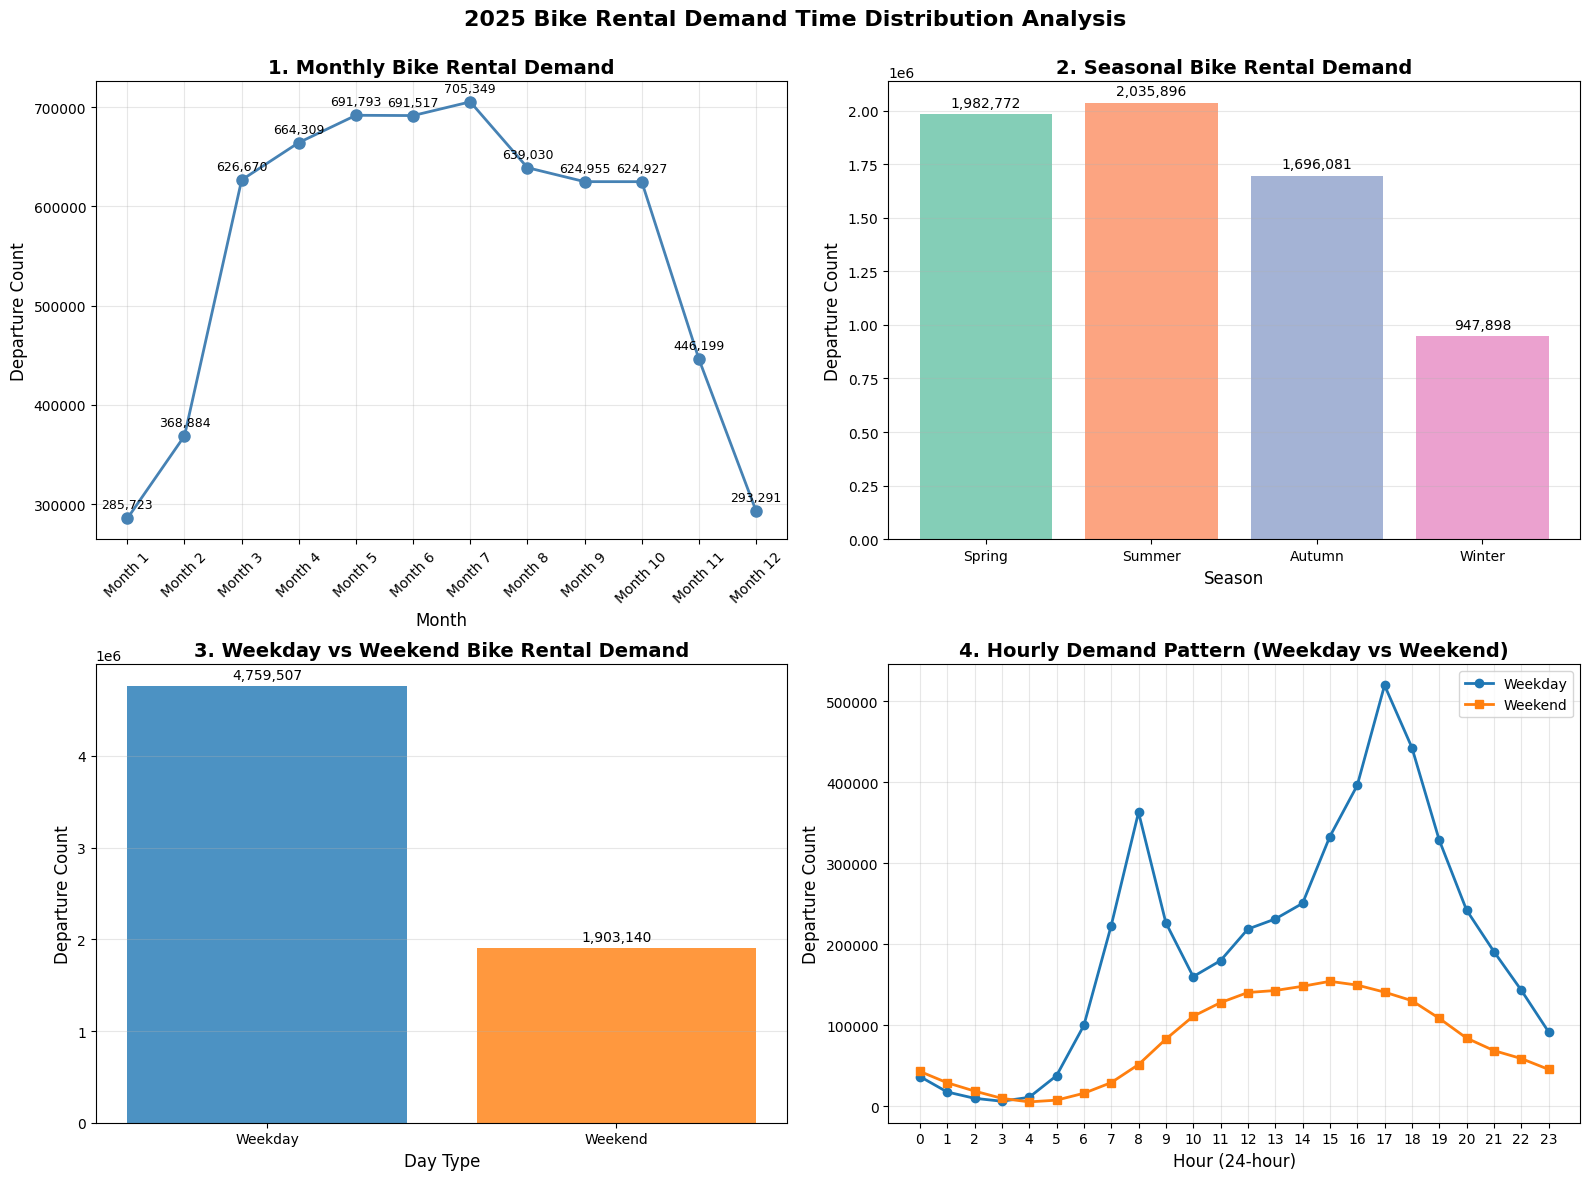

2025 Bike Rental Demand Time Analysis Summary

1. Total annual departures: 6,662,647

2. Monthly demand statistics:
   Jan: 285,723
   Feb: 368,884
   Mar: 626,670
   Apr: 664,309
   May: 691,793
   Jun: 691,517
   Jul: 705,349
   Aug: 639,030
   Sep: 624,955
   Oct: 624,927
   Nov: 446,199
   Dec: 293,291

3. Seasonal demand statistics:
   Spring: 1,982,772
   Summer: 2,035,896
   Autumn: 1,696,081
   Winter: 947,898

4. Weekday/Weekend statistics:
   Weekday: 4,759,507 (71.4%)
   Weekend: 1,903,140 (28.6%)

5. Peak demand month:
   Month 7: 705,349

6. Weekday vs Weekend ratio:
   Weekday:Weekend = 2.50:1

7. Daily demand by weekday:
   Mon: 879,571
   Tue: 935,570
   Wed: 959,672
   Thu: 986,781
   Fri: 997,913
   Sat: 1,021,602
   Sun: 881,538


In [30]:
# Ensure start_time is datetime type
trips['start_time'] = pd.to_datetime(trips['start_time'])

# Extract time features
trips['month'] = trips['start_time'].dt.month
trips['hour'] = trips['start_time'].dt.hour
trips['day_of_week'] = trips['start_time'].dt.dayofweek  # 0=Monday, 6=Sunday
trips['date'] = trips['start_time'].dt.date

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

trips['season'] = trips['month'].apply(get_season)

# Define weekday/weekend
trips['is_weekend'] = trips['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
trips['day_type'] = trips['is_weekend'].apply(lambda x: 'Weekend' if x == 1 else 'Weekday')

# Count departures by month
monthly_demand = trips.groupby('month').size().reset_index(name='Departure Count')
monthly_demand['month_name'] = monthly_demand['month'].apply(lambda x: f'Month {x}')

# Count departures by season
seasonal_demand = trips.groupby('season').size().reset_index(name='Departure Count')
# Sort by season order
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_demand['season'] = pd.Categorical(seasonal_demand['season'], categories=season_order, ordered=True)
seasonal_demand = seasonal_demand.sort_values('season')

# Count departures by weekday/weekend
daytype_demand = trips.groupby('day_type').size().reset_index(name='Departure Count')

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('2025 Bike Rental Demand Time Distribution Analysis', fontsize=16, fontweight='bold')

# Subplot 1: Monthly demand curve
ax1 = axes[0, 0]
ax1.plot(monthly_demand['month_name'], monthly_demand['Departure Count'], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_title('1. Monthly Bike Rental Demand', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Departure Count', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add data labels
max_monthly = max(monthly_demand['Departure Count'])
for i, (month, count) in enumerate(zip(monthly_demand['month_name'], monthly_demand['Departure Count'])):
    ax1.text(i, count + max_monthly*0.01, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Subplot 2: Seasonal demand bar chart
ax2 = axes[0, 1]
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
bars = ax2.bar(seasonal_demand['season'], seasonal_demand['Departure Count'], 
               color=colors, alpha=0.8)
ax2.set_title('2. Seasonal Bike Rental Demand', fontsize=14, fontweight='bold')
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Departure Count', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
max_seasonal = max(seasonal_demand['Departure Count'])
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max_seasonal*0.01,
             f'{height:,}', ha='center', va='bottom', fontsize=10)

# Subplot 3: Weekday vs Weekend demand bar chart
ax3 = axes[1, 0]
daytype_colors = ['#1f77b4', '#ff7f0e']
bars3 = ax3.bar(daytype_demand['day_type'], daytype_demand['Departure Count'], 
                color=daytype_colors, alpha=0.8)
ax3.set_title('3. Weekday vs Weekend Bike Rental Demand', fontsize=14, fontweight='bold')
ax3.set_xlabel('Day Type', fontsize=12)
ax3.set_ylabel('Departure Count', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
max_daytype = max(daytype_demand['Departure Count'])
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + max_daytype*0.01,
             f'{height:,}', ha='center', va='bottom', fontsize=10)

# Subplot 4: Hourly demand pattern (Weekday vs Weekend)
ax4 = axes[1, 1]

# Count by hour and day type
hourly_pattern = trips.groupby(['hour', 'day_type']).size().reset_index(name='Departure Count')
weekday_data = hourly_pattern[hourly_pattern['day_type'] == 'Weekday']
weekend_data = hourly_pattern[hourly_pattern['day_type'] == 'Weekend']

# Plot curves
ax4.plot(weekday_data['hour'], weekday_data['Departure Count'], 
         marker='o', linewidth=2, markersize=6, label='Weekday', color='#1f77b4')
ax4.plot(weekend_data['hour'], weekend_data['Departure Count'], 
         marker='s', linewidth=2, markersize=6, label='Weekend', color='#ff7f0e')

ax4.set_title('4. Hourly Demand Pattern (Weekday vs Weekend)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Hour (24-hour)', fontsize=12)
ax4.set_ylabel('Departure Count', fontsize=12)
ax4.set_xticks(range(0, 24))
ax4.legend()
ax4.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Print summary statistics
print("=" * 60)
print("2025 Bike Rental Demand Time Analysis Summary")
print("=" * 60)

print(f"\n1. Total annual departures: {len(trips):,}")

print("\n2. Monthly demand statistics:")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month_num in range(1, 13):
    month_data = monthly_demand[monthly_demand['month'] == month_num]
    if not month_data.empty:
        count = month_data['Departure Count'].values[0]
        print(f"   {month_names[month_num-1]}: {count:,}")
    else:
        print(f"   {month_names[month_num-1]}: No data")

print("\n3. Seasonal demand statistics:")
for _, row in seasonal_demand.iterrows():
    print(f"   {row['season']}: {row['Departure Count']:,}")

print("\n4. Weekday/Weekend statistics:")
weekday_count = daytype_demand[daytype_demand['day_type'] == 'Weekday']['Departure Count'].values[0]
weekend_count = daytype_demand[daytype_demand['day_type'] == 'Weekend']['Departure Count'].values[0]
total_count = len(trips)
print(f"   Weekday: {weekday_count:,} ({(weekday_count/total_count*100):.1f}%)")
print(f"   Weekend: {weekend_count:,} ({(weekend_count/total_count*100):.1f}%)")

print("\n5. Peak demand month:")
max_month_row = monthly_demand.loc[monthly_demand['Departure Count'].idxmax()]
print(f"   {max_month_row['month_name']}: {max_month_row['Departure Count']:,}")

print("\n6. Weekday vs Weekend ratio:")
print(f"   Weekday:Weekend = {weekday_count/weekend_count:.2f}:1")

# Additional analysis: Daily demand by weekday
print("\n7. Daily demand by weekday:")
trips['day_name'] = trips['start_time'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_demand = trips.groupby('day_name').size().reindex(weekday_order).reset_index(name='Departure Count')
weekday_demand['day_name_short'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for _, row in weekday_demand.iterrows():
    print(f"   {row['day_name_short']}: {row['Departure Count']:,}")

Q2: Study of Bike Rental Locations
 Based on the number of bike rentals at each station, create two charts:
 1. A bar chart with station names on the x-axis and the number of rentals (departure count) on the y-axis.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_208648\3606071897.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  station_departures = trips_with_stations.groupby(['start_station', 'start_station_id']).size().reset_index(name='Departure Count')


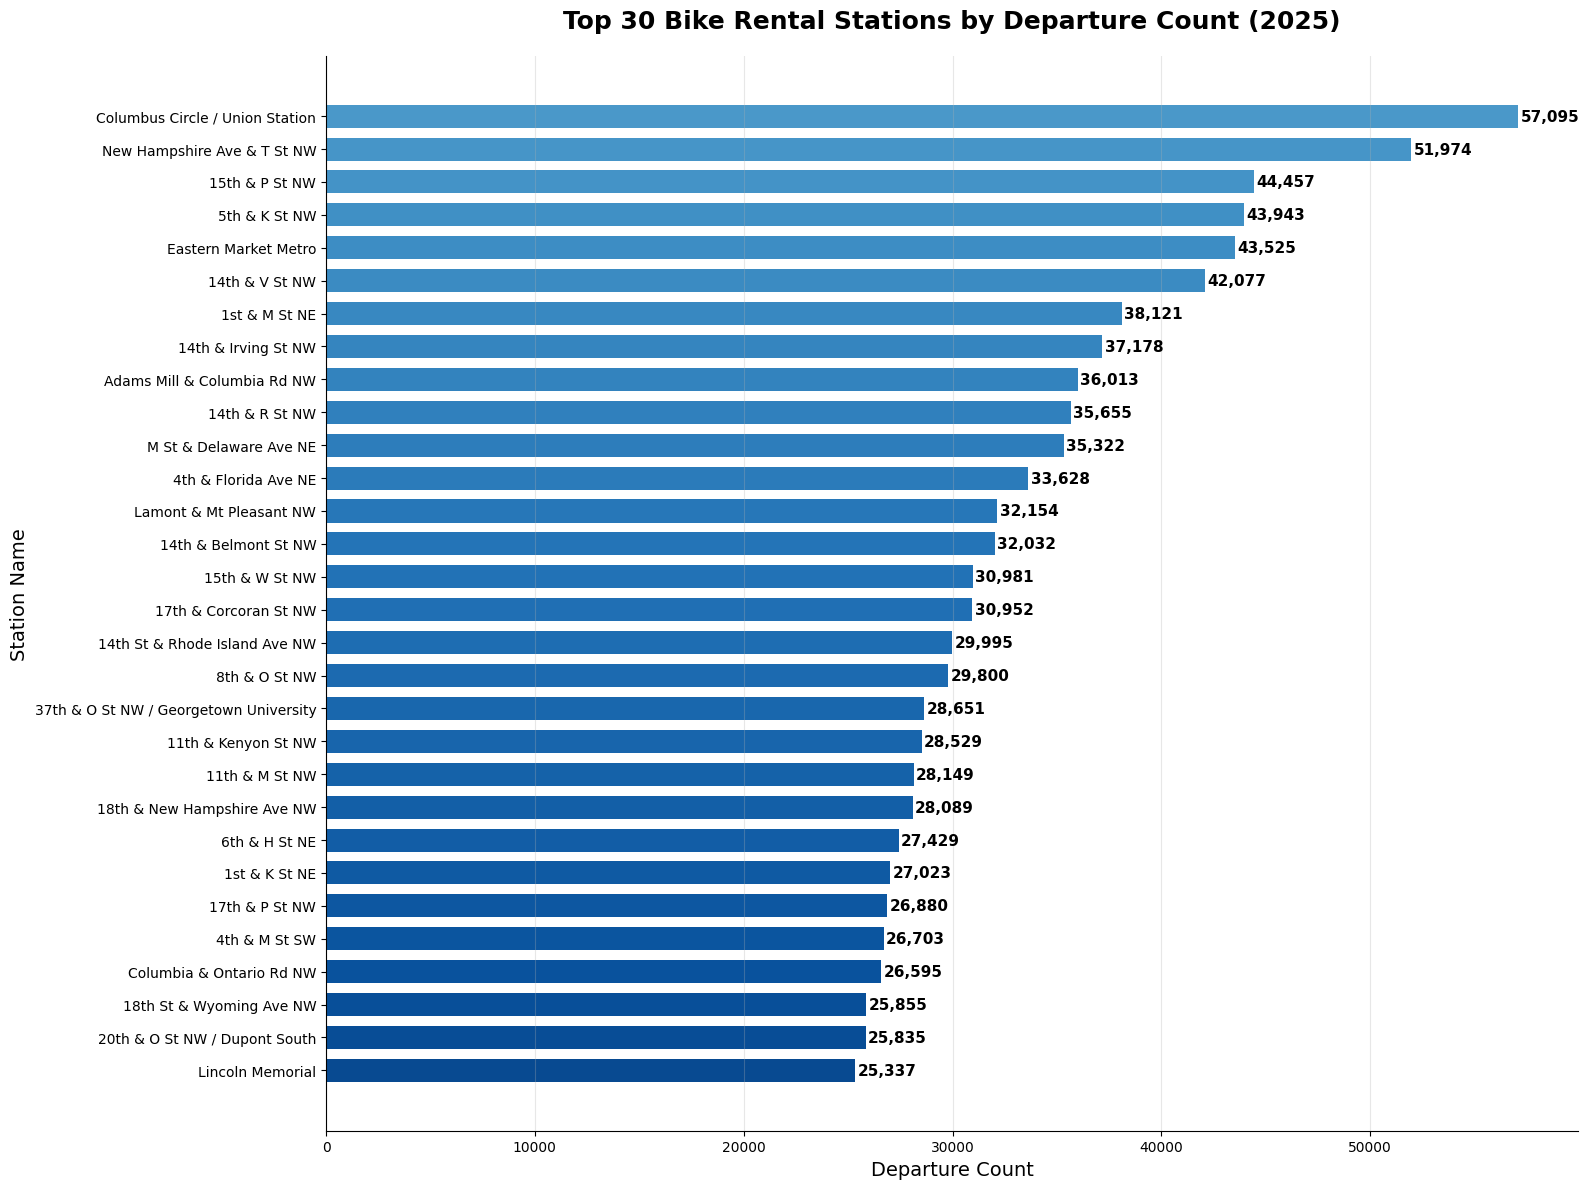

In [31]:
# Filter out trips with missing station information
trips_with_stations = trips.dropna(subset=['start_station', 'start_station_id'])

# Count departures per station
station_departures = trips_with_stations.groupby(['start_station', 'start_station_id']).size().reset_index(name='Departure Count')

# Sort by departure count and get top 30
top_30_stations = station_departures.sort_values('Departure Count', ascending=False).head(30)

# Create horizontal bar chart
plt.figure(figsize=(16, 12))

# Use a color gradient (blue to purple)
colors = plt.cm.Blues(np.linspace(0.6, 0.9, len(top_30_stations)))

bars = plt.barh(top_30_stations['start_station'], top_30_stations['Departure Count'], color=colors, height=0.7)
plt.title('Top 30 Bike Rental Stations by Departure Count (2025)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Departure Count', fontsize=14)
plt.ylabel('Station Name', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
max_count = max(top_30_stations['Departure Count'])
for bar, count in zip(bars, top_30_stations['Departure Count']):
    width = bar.get_width()
    plt.text(width + max_count * 0.002,  # Small offset from the bar
             bar.get_y() + bar.get_height()/2,
             f'{count:,}', 
             ha='left', va='center', fontsize=11, fontweight='bold')

# Invert y-axis to have highest count at top
plt.gca().invert_yaxis()

# Remove top and right spines for cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Q2经纬度图
1. 生成空间密度热力图：使用黄-橙-红色渐变, 显示使用密度的空间分布
2. 热点分析（前10%使用率）：
识别90百分位数以上的车站
分析热点车站的数量和比例
计算热点车站的总出发次数占比
分析热点的地理分布特征
3. 使用频率百分位数分布：
显示关键百分位数（0, 10, 25, 50, 75, 90, 95, 99, 100）
计算四分位距（IQR）
分析分布形状（偏度）

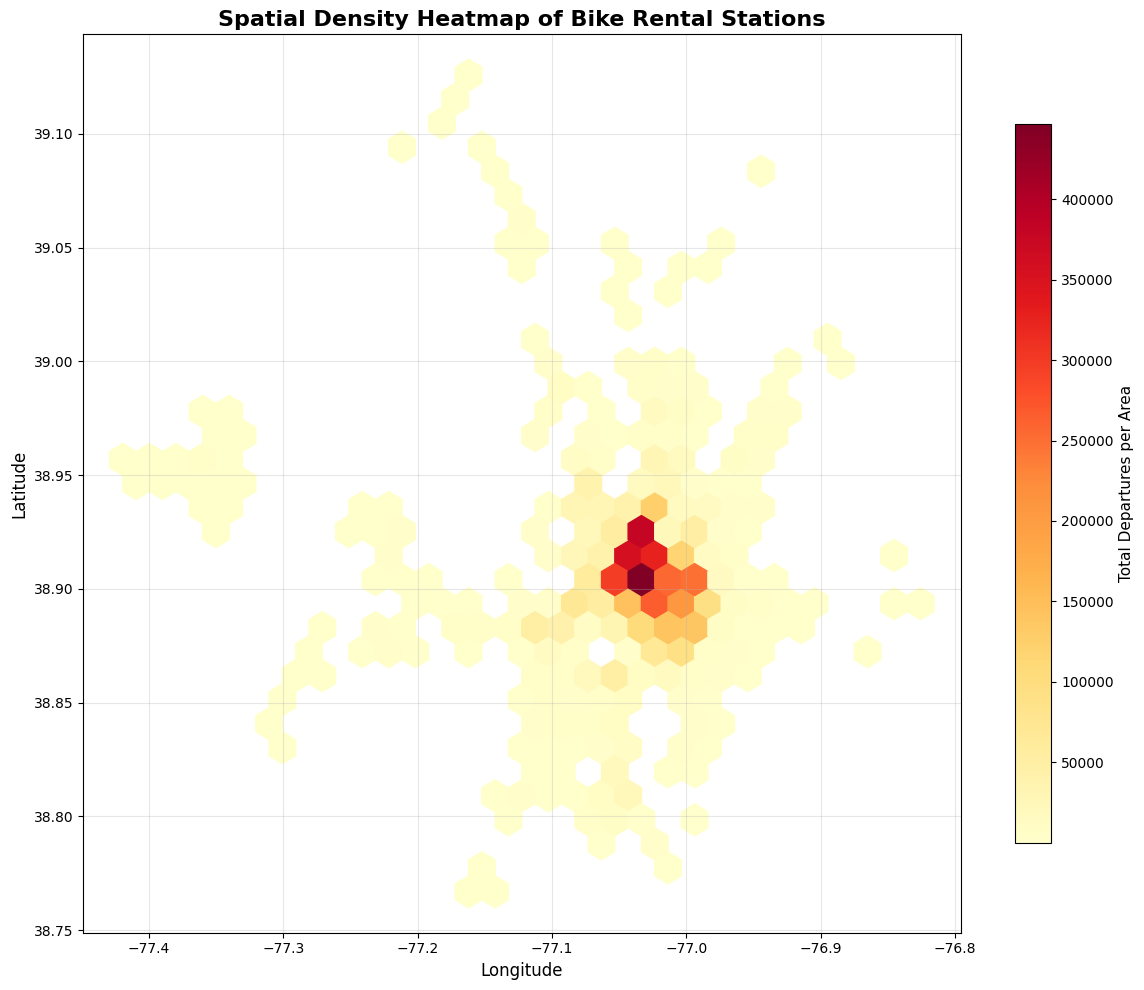

HOTSPOT ANALYSIS (TOP 10% USAGE STATIONS)

Total stations analyzed: 848
Hotspot threshold (90th percentile): 17,889 departures
Number of hotspot stations: 86
Percentage of stations that are hotspots: 10.1%

Hotspot usage statistics:
  Total departures from hotspots: 2,159,844
  Percentage of all departures: 41.7%
  Average departures per hotspot: 25,114
  Range: 17,889 - 57,095 departures

Hotspot geographic characteristics:
  Latitude range: 38.8769 to 38.9380
  Longitude range: -77.0717 to -76.9883
  Geographic center: (38.9086, -77.0283)

USAGE FREQUENCY PERCENTILE DISTRIBUTION

Percentile   Departures      Description         
--------------------------------------------------
0th:                   1    Minimum
10th:                 190    Top 90%
25th:                 554    Top 75%
50th:               2,272    Median
75th:               9,158    Top 25%
90th:              17,889    Top 10%
95th:              22,068    Top 5%
99th:              35,845    Top 1%
100th:            

In [9]:
# Filter out trips with missing station information
trips_with_stations = trips.dropna(subset=['start_station', 'start_station_id'])

# Count departures per station
station_departures = trips_with_stations.groupby(['start_station_id']).size().reset_index(name='Departure_Count')

# Merge with station information to get coordinates
station_usage = pd.merge(station_departures, stations, 
                         left_on='start_station_id', 
                         right_on='id', 
                         how='inner')

# Remove stations without coordinates
station_usage = station_usage.dropna(subset=['lat', 'lng'])

# ========================================
# Plot: Spatial Density Heatmap
# ========================================
plt.figure(figsize=(12, 10))

# Create hexbin plot
hexbin = plt.hexbin(station_usage['lng'], station_usage['lat'],
                   C=station_usage['Departure_Count'],
                   gridsize=30,
                   cmap='YlOrRd',
                   reduce_C_function=np.sum,
                   mincnt=1)

plt.title('Spatial Density Heatmap of Bike Rental Stations', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(hexbin, shrink=0.8)
cbar.set_label('Total Departures per Area', fontsize=11)

plt.tight_layout()
plt.savefig('station_density_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ========================================
# Hotspot Analysis (Top 10% usage)
# ========================================
print("=" * 70)
print("HOTSPOT ANALYSIS (TOP 10% USAGE STATIONS)")
print("=" * 70)

# Calculate threshold for top 10%
top_10_threshold = station_usage['Departure_Count'].quantile(0.90)
hotspots = station_usage[station_usage['Departure_Count'] >= top_10_threshold]

print(f"\nTotal stations analyzed: {len(station_usage):,}")
print(f"Hotspot threshold (90th percentile): {top_10_threshold:,.0f} departures")
print(f"Number of hotspot stations: {len(hotspots):,}")
print(f"Percentage of stations that are hotspots: {(len(hotspots)/len(station_usage)*100):.1f}%")

print(f"\nHotspot usage statistics:")
print(f"  Total departures from hotspots: {hotspots['Departure_Count'].sum():,}")
print(f"  Percentage of all departures: {(hotspots['Departure_Count'].sum()/station_usage['Departure_Count'].sum()*100):.1f}%")
print(f"  Average departures per hotspot: {hotspots['Departure_Count'].mean():,.0f}")
print(f"  Range: {hotspots['Departure_Count'].min():,} - {hotspots['Departure_Count'].max():,} departures")

# Hotspot geographic analysis
if len(hotspots) > 0:
    print(f"\nHotspot geographic characteristics:")
    print(f"  Latitude range: {hotspots['lat'].min():.4f} to {hotspots['lat'].max():.4f}")
    print(f"  Longitude range: {hotspots['lng'].min():.4f} to {hotspots['lng'].max():.4f}")
    
    # Calculate hotspot center
    hotspot_center_lat = hotspots['lat'].mean()
    hotspot_center_lng = hotspots['lng'].mean()
    print(f"  Geographic center: ({hotspot_center_lat:.4f}, {hotspot_center_lng:.4f})")

# ========================================
# Usage Frequency Percentile Distribution
# ========================================
print("\n" + "=" * 70)
print("USAGE FREQUENCY PERCENTILE DISTRIBUTION")
print("=" * 70)

# Calculate percentiles
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = {}

print(f"\n{'Percentile':<12} {'Departures':<15} {'Description':<20}")
print("-" * 50)

for p in percentiles:
    value = station_usage['Departure_Count'].quantile(p/100) if p < 100 else station_usage['Departure_Count'].max()
    percentile_values[p] = value
    
    # Add description
    if p == 0:
        desc = "Minimum"
    elif p == 50:
        desc = "Median"
    elif p == 100:
        desc = "Maximum"
    else:
        desc = f"Top {100-p}%"
    
    print(f"{p}th:        {value:>12,.0f}    {desc}")

# Interquartile range analysis
q25 = percentile_values[25]
q75 = percentile_values[75]
iqr = q75 - q25
print(f"\nInterquartile Range (IQR): {iqr:,.0f} departures")
print(f"Q1 (25th percentile): {q25:,.0f}")
print(f"Q3 (75th percentile): {q75:,.0f}")

# Distribution shape analysis
mean_usage = station_usage['Departure_Count'].mean()
median_usage = percentile_values[50]
if mean_usage > median_usage:
    shape = "Right-skewed (few high-usage stations)"
elif mean_usage < median_usage:
    shape = "Left-skewed (many low-usage stations)"
else:
    shape = "Symmetric"

print(f"\nDistribution shape: {shape}")
print(f"  Mean: {mean_usage:,.0f}")
print(f"  Median: {median_usage:,.0f}")
print(f"  Mean/Median ratio: {mean_usage/median_usage:.2f}")

基于出发次数最多的前30个车站的OD matrix

In [35]:
# Filter out trips with missing station information
trips_with_stations = trips.dropna(subset=['start_station_id', 'end_station_id'])

# Count trips for each OD pair
od_flows = trips_with_stations.groupby(['start_station_id', 'end_station_id']).size().reset_index(name='flow_count')

# Get station names
station_names = stations.set_index('id')['name'].to_dict()

# Get top 30 stations by departures
station_departures = trips_with_stations.groupby('start_station_id').size().reset_index(name='departures')
top_30_stations = station_departures.nlargest(30, 'departures')['start_station_id'].tolist()

# Create OD matrix for top 30 stations
od_matrix = pd.DataFrame(0, index=top_30_stations, columns=top_30_stations, dtype=int)

# Fill the matrix
for _, row in od_flows.iterrows():
    start_id = row['start_station_id']
    end_id = row['end_station_id']
    if start_id in top_30_stations and end_id in top_30_stations:
        od_matrix.loc[start_id, end_id] = row['flow_count']

# Convert IDs to station names for readability
station_id_to_name = {sid: station_names.get(sid, f"Station_{int(sid)}") for sid in top_30_stations}

# Create a version with readable names
od_matrix_named = od_matrix.copy()
od_matrix_named.index = [station_id_to_name[idx] for idx in od_matrix_named.index]
od_matrix_named.columns = [station_id_to_name[col] for col in od_matrix_named.columns]

# Shorten names for display
def shorten_name(name, max_len=20):
    if len(name) <= max_len:
        return name
    return name[:max_len-3] + "..."

od_matrix_display = od_matrix_named.copy()
od_matrix_display.index = [shorten_name(name) for name in od_matrix_display.index]
od_matrix_display.columns = [shorten_name(name) for name in od_matrix_display.columns]

# ========================================
# 输出OD矩阵
# ========================================
print("OD Matrix (30×30):")
print(od_matrix_display)
# Saved as Excel file
od_matrix_display.to_excel('od_matrix_top30_stations.xlsx')

OD Matrix (30×30):
                      Columbus Circle /...  New Hampshire Ave...  \
Columbus Circle /...                   933                    60   
New Hampshire Ave...                    38                   938   
5th & K St NW                          334                   352   
Eastern Market Metro                   479                    14   
15th & P St NW                          76                  1941   
14th & V St NW                          74                   319   
1st & M St NE                          399                   132   
14th & R St NW                          59                   503   
M St & Delaware A...                   594                   119   
Adams Mill & Colu...                    49                   407   
4th & Florida Ave NE                   540                    91   
15th & W St NW                          65                   337   
17th & Corcoran S...                    38                  1104   
14th & Irving St NW          

图表1：骑行时间和距离分布
骑行时间直方图：对数刻度显示骑行时间分布
骑行时间箱线图：显示统计数据，去除极端值
骑行距离直方图：对数刻度显示骑行距离分布
距离vs时间散点图：显示两者关系

图表2：骑行起始时间分布
24小时分布：显示一天中各小时的骑行数量
星期分布：比较工作日和周末的差异
热力图：显示小时和星期的组合分布
月度分布：显示各月份的骑行数量

详细统计输出包括：
骑行时间的基本统计（均值、中位数、标准差等）
骑行时间的百分位数
骑行距离统计（如果有数据）
起始时间分析（最繁忙/空闲时段）
星期和月度统计
骑行速度分析（如果有距离数据）

RIDE DURATION ANALYSIS

Data Statistics:
  Total trips: 6,662,647
  Valid trips (1 min to 24 hours): 6,508,631
  Outliers filtered: 154,016 (2.3%)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_208648\3371219504.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_distance['distance_km'] = valid_distance['distance_m'] / 1000


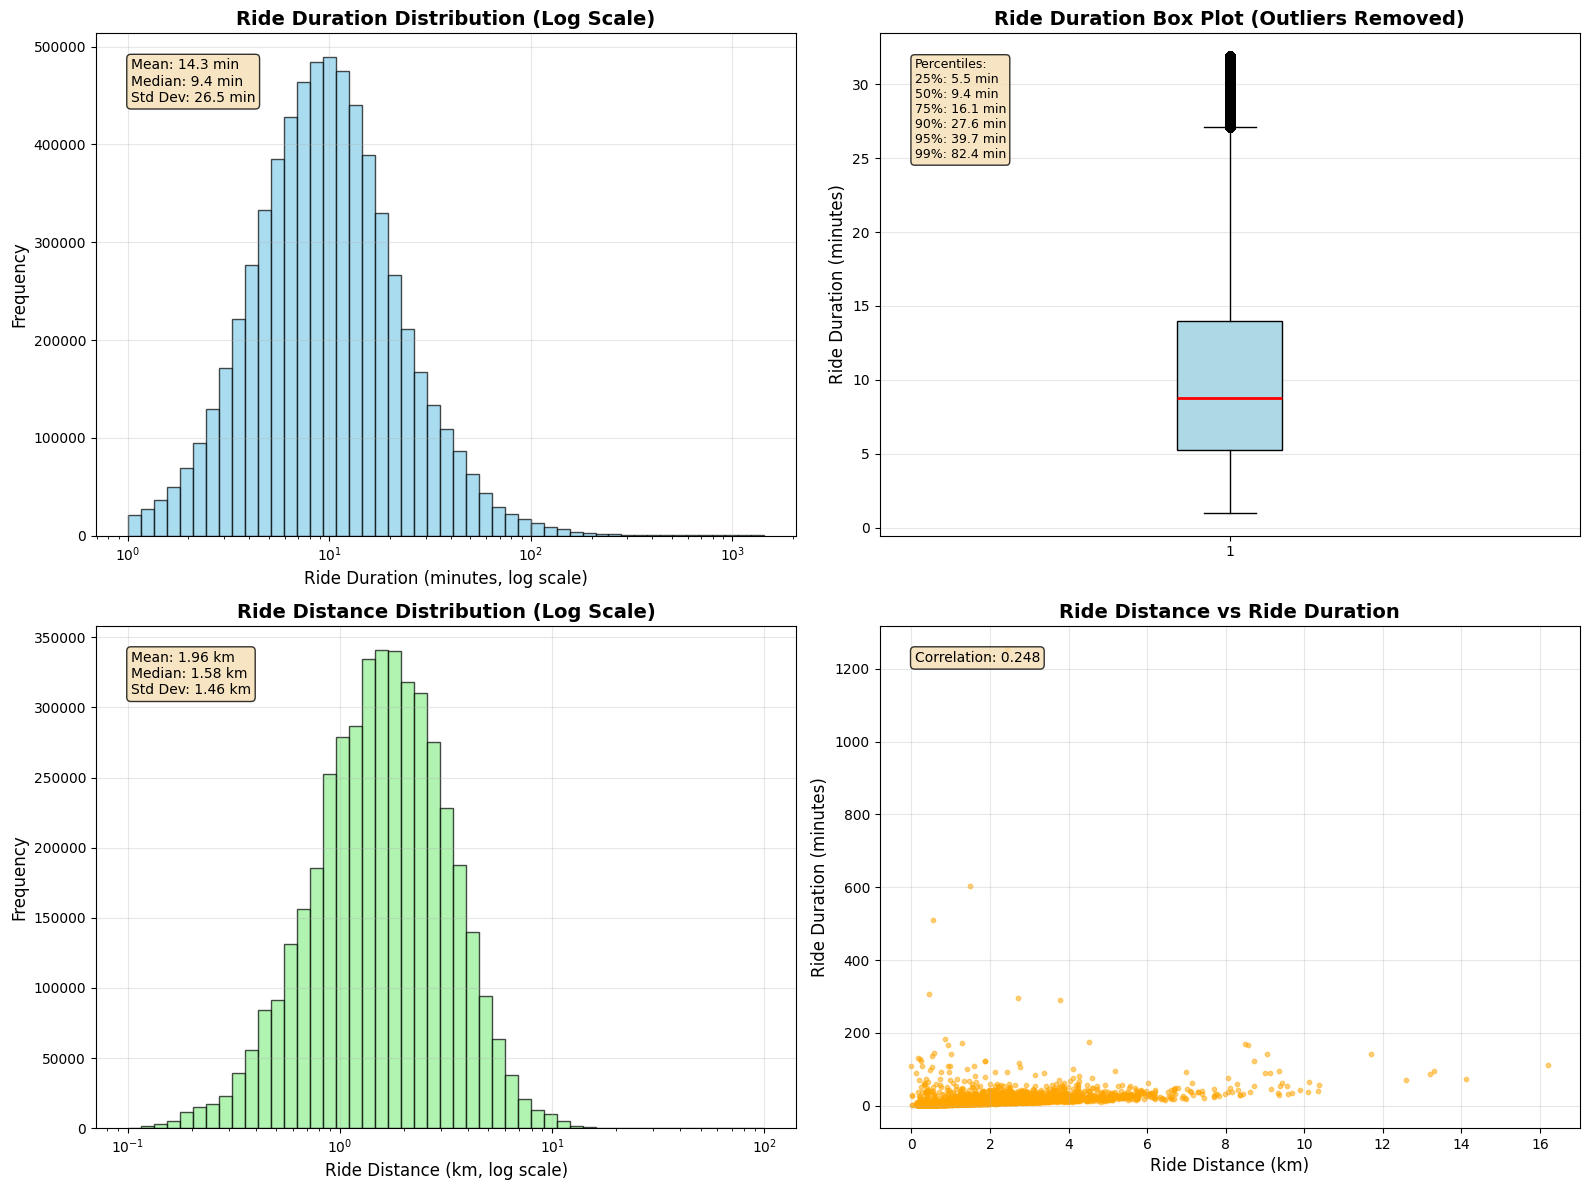

C:\Users\lenovo\AppData\Local\Temp\ipykernel_208648\3371219504.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_trips['start_hour'] = valid_trips['start_time'].dt.hour
C:\Users\lenovo\AppData\Local\Temp\ipykernel_208648\3371219504.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_trips['start_weekday'] = valid_trips['start_time'].dt.dayofweek  # 0=Monday, 6=Sunday
C:\Users\lenovo\AppData\Local\Temp\ipykernel_208648\3371219504.py:236: SettingWithCopyWarning: 
A value is trying to be set 

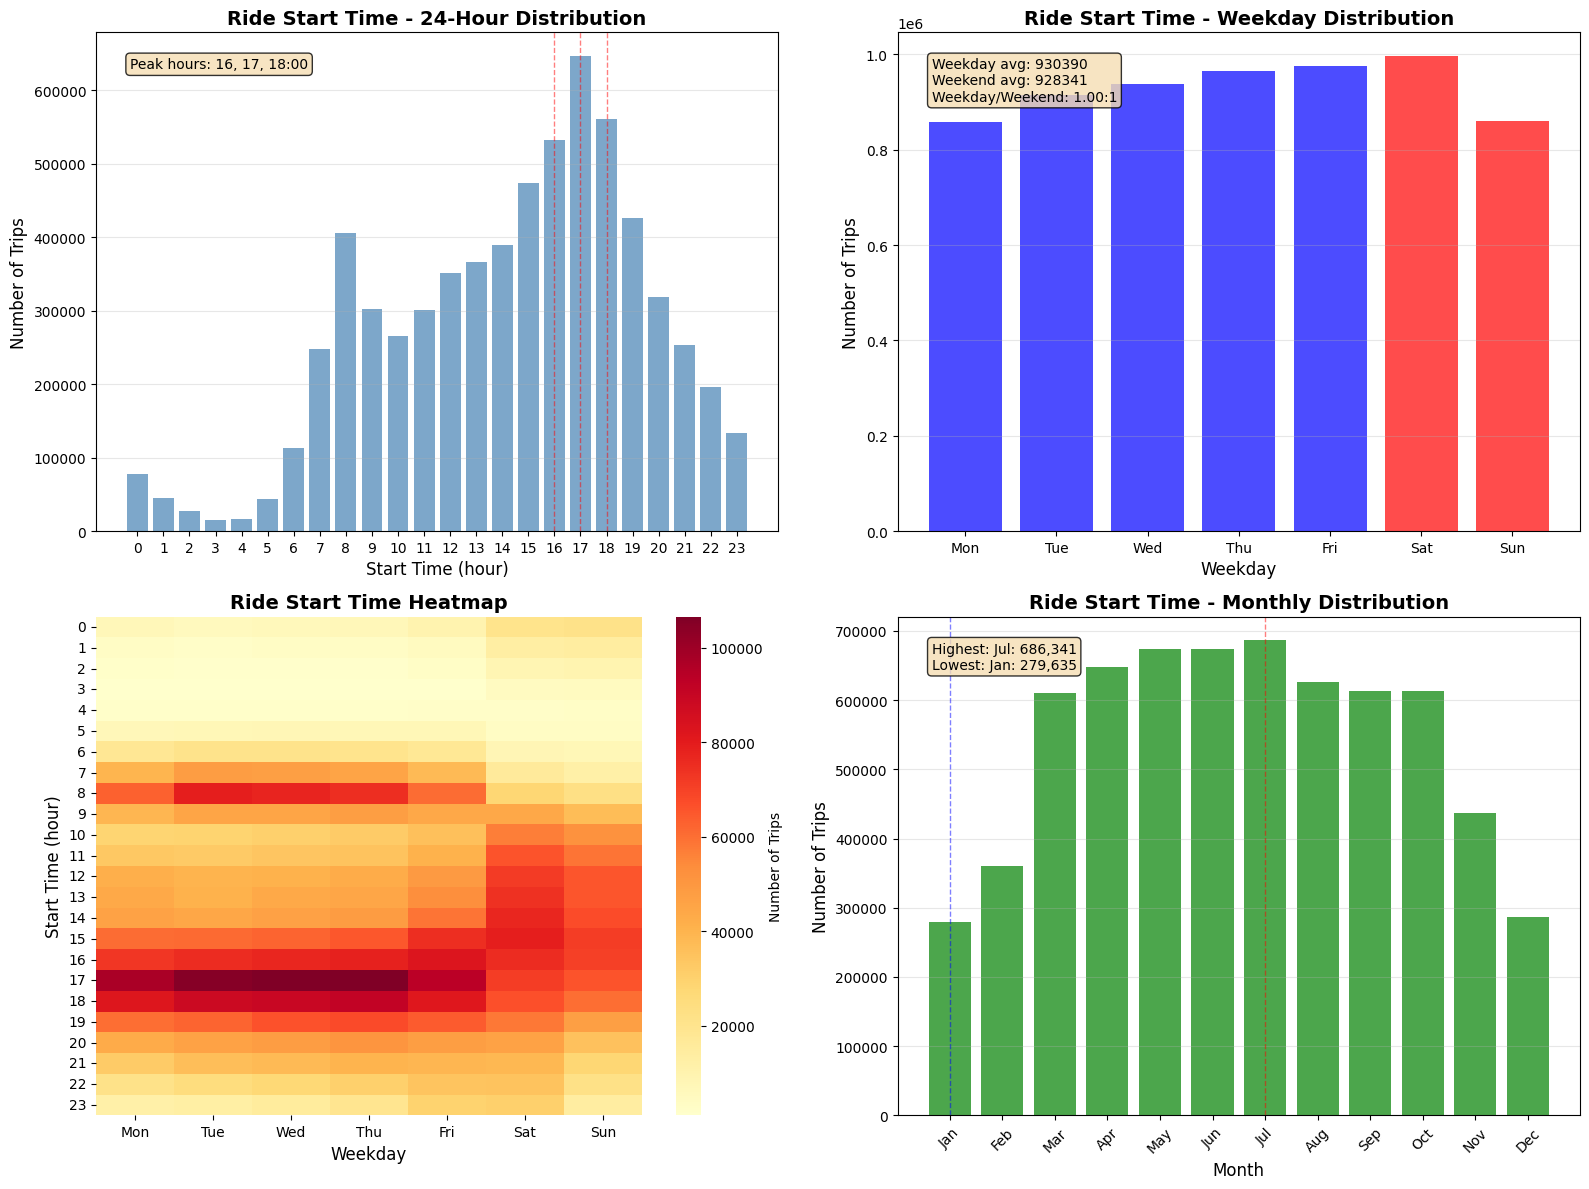


DETAILED STATISTICS

Ride Duration Statistics (minutes):
  Minimum: 1.0
  Maximum: 1439.9
  Mean: 14.3
  Median: 9.4
  Standard Deviation: 26.5
  Skewness: 25.395
  Kurtosis: 1014.055

Ride Duration Percentiles (minutes):
  5%: 2.5
  10%: 3.4
  25%: 5.5
  50%: 9.4
  75%: 16.1
  90%: 27.6
  95%: 39.7
  99%: 82.4

Ride Distance Statistics (km):
  Minimum: 0.00
  Maximum: 32.59
  Mean: 1.96
  Median: 1.58
  Standard Deviation: 1.46

Ride Distance Percentiles (km):
  5%: 0.45
  10%: 0.60
  25%: 0.96
  50%: 1.58
  75%: 2.54
  90%: 3.75
  95%: 4.67
  99%: 7.16

Ride Start Time Statistics:
  Busiest hour: 17:00 (646,661 trips)
  Quietest hour: 3:00 (15,293 trips)

Statistics by Weekday:
  Mon: 859,030 trips
  Tue: 914,335 trips
  Wed: 938,726 trips
  Thu: 964,768 trips
  Fri: 975,090 trips
  Sat: 996,672 trips
  Sun: 860,010 trips

Statistics by Month:
  Jan: 279,635 trips
  Feb: 359,849 trips
  Mar: 610,314 trips
  Apr: 647,882 trips
  May: 673,759 trips
  Jun: 673,630 trips
  Jul: 686,341 

In [22]:
# Ensure start_time is datetime type
trips['start_time'] = pd.to_datetime(trips['start_time'])
trips['end_time'] = pd.to_datetime(trips['end_time'])

# ========================================
# 1. Calculate ride duration (minutes)
# ========================================

# Calculate ride duration (seconds)
trips['ride_duration_sec'] = (trips['end_time'] - trips['start_time']).dt.total_seconds()

# Convert to minutes
trips['ride_duration_min'] = trips['ride_duration_sec'] / 60

# Filter outliers: ride duration between 1 minute and 24 hours
valid_trips = trips[(trips['ride_duration_min'] >= 1) & (trips['ride_duration_min'] <= 1440)]

print("=" * 80)
print("RIDE DURATION ANALYSIS")
print("=" * 80)

print(f"\nData Statistics:")
print(f"  Total trips: {len(trips):,}")
print(f"  Valid trips (1 min to 24 hours): {len(valid_trips):,}")
print(f"  Outliers filtered: {len(trips) - len(valid_trips):,} ({(len(trips) - len(valid_trips))/len(trips)*100:.1f}%)")

# ========================================
# 2. Ride Duration Distribution Analysis
# ========================================

plt.figure(figsize=(16, 12))

# Subplot 1: Ride duration histogram
ax1 = plt.subplot(2, 2, 1)

# Use log scale since data might be right-skewed
hist_data = valid_trips['ride_duration_min']
bins = np.logspace(np.log10(1), np.log10(1440), 50)  # Log-spaced bins

plt.hist(hist_data, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
plt.xscale('log')
plt.xlabel('Ride Duration (minutes, log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Ride Duration Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add statistics
mean_duration = hist_data.mean()
median_duration = hist_data.median()
std_duration = hist_data.std()

ax1.text(0.05, 0.95, f'Mean: {mean_duration:.1f} min\nMedian: {median_duration:.1f} min\nStd Dev: {std_duration:.1f} min',
         transform=ax1.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 2: Ride duration box plot
ax2 = plt.subplot(2, 2, 2)

# Remove extreme values for display
q1 = hist_data.quantile(0.25)
q3 = hist_data.quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5 * iqr

filtered_data = hist_data[hist_data <= upper_limit]

plt.boxplot(filtered_data, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red', linewidth=2))
plt.ylabel('Ride Duration (minutes)', fontsize=12)
plt.title('Ride Duration Box Plot (Outliers Removed)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Add percentile information
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = hist_data.quantile([p/100 for p in percentiles])

ax2.text(0.05, 0.95, 'Percentiles:\n' + 
         '\n'.join([f'{p}%: {v:.1f} min' for p, v in zip(percentiles, percentile_values)]),
         transform=ax2.transAxes, fontsize=9,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ========================================
# 3. Ride Distance Distribution Analysis
# ========================================

# Check if distance data exists
has_distance_data = 'distance_m' in trips.columns

if has_distance_data:
    # Filter abnormal distance values (between 1 meter and 100 km)
    valid_distance = valid_trips[(valid_trips['distance_m'] >= 1) & (valid_trips['distance_m'] <= 100000)]
    
    # Convert to kilometers
    valid_distance['distance_km'] = valid_distance['distance_m'] / 1000
    
    # Subplot 3: Ride distance histogram
    ax3 = plt.subplot(2, 2, 3)
    
    dist_data = valid_distance['distance_km']
    dist_bins = np.logspace(np.log10(0.1), np.log10(100), 50)  # 0.1km to 100km
    
    plt.hist(dist_data, bins=dist_bins, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.xscale('log')
    plt.xlabel('Ride Distance (km, log scale)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Ride Distance Distribution (Log Scale)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add statistics
    mean_dist = dist_data.mean()
    median_dist = dist_data.median()
    std_dist = dist_data.std()
    
    ax3.text(0.05, 0.95, f'Mean: {mean_dist:.2f} km\nMedian: {median_dist:.2f} km\nStd Dev: {std_dist:.2f} km',
             transform=ax3.transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Subplot 4: Ride distance vs ride duration scatter plot
    ax4 = plt.subplot(2, 2, 4)
    
    # Sample some data to avoid overcrowding
    sample_size = min(5000, len(valid_distance))
    sample_data = valid_distance.sample(sample_size, random_state=42)
    
    plt.scatter(sample_data['distance_km'], sample_data['ride_duration_min'],
               alpha=0.5, s=10, color='orange')
    plt.xlabel('Ride Distance (km)', fontsize=12)
    plt.ylabel('Ride Duration (minutes)', fontsize=12)
    plt.title('Ride Distance vs Ride Duration', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation coefficient
    correlation = valid_distance['distance_km'].corr(valid_distance['ride_duration_min'])
    
    ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=ax4.transAxes, fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
else:
    # If no distance data, use empty subplots
    ax3 = plt.subplot(2, 2, 3)
    ax3.text(0.5, 0.5, 'No ride distance data', ha='center', va='center', fontsize=12)
    ax3.set_title('Ride Distance Distribution', fontsize=14, fontweight='bold')
    
    ax4 = plt.subplot(2, 2, 4)
    ax4.text(0.5, 0.5, 'No ride distance data', ha='center', va='center', fontsize=12)
    ax4.set_title('Distance vs Duration', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ========================================
# 4. Ride Start Time Distribution Analysis
# ========================================

plt.figure(figsize=(16, 12))

# Extract hour information
valid_trips['start_hour'] = valid_trips['start_time'].dt.hour
valid_trips['start_weekday'] = valid_trips['start_time'].dt.dayofweek  # 0=Monday, 6=Sunday

# Subplot 1: 24-hour distribution
ax1 = plt.subplot(2, 2, 1)

hourly_counts = valid_trips['start_hour'].value_counts().sort_index()
plt.bar(hourly_counts.index, hourly_counts.values, alpha=0.7, color='steelblue')
plt.xlabel('Start Time (hour)', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Ride Start Time - 24-Hour Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, axis='y')

# Mark peak hours
peak_hours = hourly_counts.nlargest(3).index
for hour in peak_hours:
    plt.axvline(x=hour, color='red', linestyle='--', alpha=0.5, linewidth=1)

# Add statistics
ax1.text(0.05, 0.95, f'Peak hours: {", ".join([str(h) for h in sorted(peak_hours)])}:00',
         transform=ax1.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 2: Weekday vs Weekend
ax2 = plt.subplot(2, 2, 2)

# Distinguish weekdays and weekends
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_counts = valid_trips['start_weekday'].value_counts().sort_index()

plt.bar(range(7), weekday_counts.values, alpha=0.7, color=['blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red'])
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Ride Start Time - Weekday Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(7), weekday_names)
plt.grid(True, alpha=0.3, axis='y')

# Add statistics
weekday_avg = weekday_counts[:5].mean()  # Monday to Friday
weekend_avg = weekday_counts[5:].mean()  # Saturday and Sunday
ratio = weekday_avg / weekend_avg

ax2.text(0.05, 0.95, f'Weekday avg: {weekday_avg:.0f}\nWeekend avg: {weekend_avg:.0f}\nWeekday/Weekend: {ratio:.2f}:1',
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Subplot 3: Heatmap - Hour vs Weekday
ax3 = plt.subplot(2, 2, 3)

# Create cross-tabulation
hour_weekday_table = pd.crosstab(valid_trips['start_hour'], valid_trips['start_weekday'])

# Reorder columns from Monday to Sunday
hour_weekday_table = hour_weekday_table.reindex(columns=range(7))

# Create heatmap
sns.heatmap(hour_weekday_table, cmap='YlOrRd', ax=ax3, 
            cbar_kws={'label': 'Number of Trips'})
ax3.set_xlabel('Weekday', fontsize=12)
ax3.set_ylabel('Start Time (hour)', fontsize=12)
ax3.set_title('Ride Start Time Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticklabels(weekday_names)
ax3.set_yticklabels(range(0, 24))

# Subplot 4: Monthly distribution
ax4 = plt.subplot(2, 2, 4)

# Extract month
valid_trips['start_month'] = valid_trips['start_time'].dt.month
monthly_counts = valid_trips['start_month'].value_counts().sort_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.bar(monthly_counts.index, monthly_counts.values, alpha=0.7, color='green')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Ride Start Time - Monthly Distribution', fontsize=14, fontweight='bold')
plt.xticks(range(1, 13), month_names, rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Mark highest and lowest months
max_month = monthly_counts.idxmax()
min_month = monthly_counts.idxmin()
plt.axvline(x=max_month, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=min_month, color='blue', linestyle='--', alpha=0.5, linewidth=1)

ax4.text(0.05, 0.95, f'Highest: {month_names[max_month-1]}: {monthly_counts[max_month]:,}\nLowest: {month_names[min_month-1]}: {monthly_counts[min_month]:,}',
         transform=ax4.transAxes, fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# ========================================
# 5. Detailed Statistics Output
# ========================================

print("\n" + "=" * 80)
print("DETAILED STATISTICS")
print("=" * 80)

print(f"\nRide Duration Statistics (minutes):")
print(f"  Minimum: {valid_trips['ride_duration_min'].min():.1f}")
print(f"  Maximum: {valid_trips['ride_duration_min'].max():.1f}")
print(f"  Mean: {mean_duration:.1f}")
print(f"  Median: {median_duration:.1f}")
print(f"  Standard Deviation: {std_duration:.1f}")
print(f"  Skewness: {valid_trips['ride_duration_min'].skew():.3f}")
print(f"  Kurtosis: {valid_trips['ride_duration_min'].kurtosis():.3f}")

print(f"\nRide Duration Percentiles (minutes):")
for p in [5, 10, 25, 50, 75, 90, 95, 99]:
    value = valid_trips['ride_duration_min'].quantile(p/100)
    print(f"  {p}%: {value:.1f}")

if has_distance_data:
    print(f"\nRide Distance Statistics (km):")
    print(f"  Minimum: {dist_data.min():.2f}")
    print(f"  Maximum: {dist_data.max():.2f}")
    print(f"  Mean: {mean_dist:.2f}")
    print(f"  Median: {median_dist:.2f}")
    print(f"  Standard Deviation: {std_dist:.2f}")
    
    print(f"\nRide Distance Percentiles (km):")
    for p in [5, 10, 25, 50, 75, 90, 95, 99]:
        value = dist_data.quantile(p/100)
        print(f"  {p}%: {value:.2f}")

print(f"\nRide Start Time Statistics:")
print(f"  Busiest hour: {hourly_counts.idxmax()}:00 ({hourly_counts.max():,} trips)")
print(f"  Quietest hour: {hourly_counts.idxmin()}:00 ({hourly_counts.min():,} trips)")

print(f"\nStatistics by Weekday:")
for i, count in weekday_counts.items():
    print(f"  {weekday_names[i]}: {count:,} trips")

print(f"\nStatistics by Month:")
for month_num in range(1, 13):
    month_count = monthly_counts.get(month_num, 0)
    print(f"  {month_names[month_num-1]}: {month_count:,} trips")

# Calculate average speed (if distance data exists)
if has_distance_data:
    valid_trips_with_dist = valid_trips.merge(valid_distance[['distance_m', 'distance_km']], 
                                              left_index=True, right_index=True, how='inner')
    valid_trips_with_dist['speed_kmh'] = valid_trips_with_dist['distance_km'] / (valid_trips_with_dist['ride_duration_min'] / 60)
    
    # Filter abnormal speeds (between 3-30 km/h)
    valid_speed = valid_trips_with_dist[(valid_trips_with_dist['speed_kmh'] >= 3) & (valid_trips_with_dist['speed_kmh'] <= 30)]
    
    print(f"\nRide Speed Statistics:")
    print(f"  Average speed: {valid_speed['speed_kmh'].mean():.2f} km/h")
    print(f"  Median speed: {valid_speed['speed_kmh'].median():.2f} km/h")
    print(f"  Speed range: {valid_speed['speed_kmh'].min():.2f} - {valid_speed['speed_kmh'].max():.2f} km/h")